In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from skspatial.objects import Line
import cv2

## variables

In [39]:
#w = 693 #sticky note pixel width
#W = 0.076 #mm per pixel
#P = 3024 #pixel width of the image
##S = 0.007470#1.22e-6 * P
##f = 0.052
#S = 0.008466 # camera sensor size
#f = 0.028 # focal length
#F = f * P / S
#D = (W * F)/w  # distance to the object
#print(D)
#
#ratio=0.076/w  #um per pixel
#pupil_pixel_size = 44
#r_p = pupil_pixel_size*ratio/2 # pupil radius in mm
#print(r_p)

In [40]:
#im = "0091_H_R" # -6.0
im = "0088_V_L" # -1.75

D = 1.0           # object distance
r_p = 0.0030 # radius of pupil
e = 0.007       # eccentricity of light source
R = -2.5          # corrective lens diopter
D_cyl = -2.0      # cylinder lens diopter
axis = 0        # axis of cylinder lens
axis = np.deg2rad(axis) # convert axis to radians

l_eye = 1/60    # focal length of the eye

f_n = 1/(1/l_eye + 1/D) # focal length of normal eye
f_e = 1/(1/f_n + R) # focal length of eye with error
f_e_cyl = 1/(1/f_n + R + D_cyl) # focal length of eye with error and cylinder lens
x = abs(1/R)


## ray tracing

In [41]:
camera = (0, 0, D)
light = (0, e, D)
lens = (0, 0, 0)
retina = (0, 0, -l_eye)

In [42]:
class Ray():
    def __init__(self, start, end):
        start = np.array(start)
        end = np.array(end)
        self.start = np.array(start)
        self.end = np.array(end)
        self.dir = self.end - self.start
        self.dir = self.dir / np.linalg.norm(self.dir)

    def intersect(self, ray):
        # check if the rays are parallel
        line_a = Line(point=self.start, direction=self.dir)
        line_b = Line(point=ray.start, direction=ray.dir)
        intersection = line_a.intersect_line(line_b)
        return intersection

In [43]:
def intersect_rays(ray1, ray2):
    # check if the rays are parallel
    line_a = Line(point=ray1.start, direction=ray1.dir)
    line_b = Line(point=ray2.start, direction=ray2.dir)
    intersection = line_a.intersect_line(line_b)
    return intersection

In [44]:
class Plane():
    def __init__(self, point, normal):
        self.normal = normal
        self.point = point

    def intersect(self, ray):
        # check if the ray is parallel to the plane
        if np.dot(ray.dir, self.normal) == 0:
            return None
        # calculate intersection point
        t = np.dot(self.point - ray.start, self.normal) / np.dot(ray.dir, self.normal)
        return ray.start + t * ray.dir

In [45]:
class Lens():
    def __init__(self, center, normal, focal_length, focal_length_ast, axis):
        self.center = np.array(center)
        self.normal = np.array(normal)
        self.normal = self.normal/np.linalg.norm(self.normal)

        self.focal_length = focal_length
        self.focal_length_ast = focal_length_ast
        self.axis = axis

    def intersect(self, ray):
        # calculate intersection point of ray and lens
        t = np.dot(self.center - ray.start, self.normal) / np.dot(ray.dir, self.normal)
        intersection = ray.start + t * ray.dir
        return intersection
    
    def refract(self, ray):
        hit = self.intersect(ray)
        # calculate refracted ray
        hit_dir = hit - self.center
        axis_vector = np.array([np.cos(self.axis), np.sin(self.axis), 0])
        angle = np.arccos(np.dot(hit_dir, axis_vector) / (np.linalg.norm(hit_dir) * np.linalg.norm(axis_vector)))

        #focal_length = pow(np.sin(angle), 2) * self.focal_length_ast + pow(np.cos(angle), 2) * self.focal_length
        focal_length = 1/(1/f_n + R + pow(np.sin(angle), 2) * D_cyl)
        focal_point = self.center - self.normal * focal_length


        center_ray = Ray(ray.start, self.center)
        orthogonal_ray = Ray(ray.start, ray.start-self.normal)
        if not np.array_equal(orthogonal_ray.dir, center_ray.dir):
            ortho_hit = self.intersect(orthogonal_ray)
            ortho_refract = Ray(ortho_hit, focal_point)
            image_point = intersect_rays(center_ray, ortho_refract)
        else:
            im_distance = 1/(1/focal_length - 1/np.linalg.norm(self.center - orthogonal_ray.start))
            image_point = self.center - self.normal * im_distance
        refracted_ray = Ray(hit, image_point)
        return refracted_ray


        

In [46]:
lens_object = Lens(lens, np.array((0, 0, 1)), f_e, f_e_cyl, axis)
retina_object = Plane(retina, np.array((0, 0, 1)))

a = np.cos(axis) * r_p
b = np.sin(axis) * r_p
c = np.cos(axis+np.pi/2) * r_p
d = np.sin(axis+np.pi/2) * r_p

# cast rays from camera to 4 corners of the lens
camera_rays = []
camera_rays.append(Ray(camera, lens+ np.array((a,  b,  0))))
camera_rays.append(Ray(camera, lens+ np.array((-a, -b, 0)))) # top of crescent
camera_rays.append(Ray(camera, lens+ np.array((c,  d,  0))))
camera_rays.append(Ray(camera, lens+ np.array((-c, -d, 0))))
camera_ray_focus = camera_rays[0].intersect(camera_rays[1])
camera_hits = []

refracted_camera_rays = []
for ray in camera_rays:
    ray = lens_object.refract(ray)
    refracted_camera_rays.append(ray)
    hit = retina_object.intersect(ray)
    camera_hits.append(hit)
camera_ray_focus = refracted_camera_rays[0].intersect(refracted_camera_rays[1])
camera_ray_focus2 = refracted_camera_rays[2].intersect(refracted_camera_rays[3])
image_point_cam = np.mean([camera_ray_focus, camera_ray_focus2], axis=0)

camera_hits = np.array(camera_hits)

light_rays = []
light_rays.append(Ray(light, lens+ np.array((a,  b,  0))))
light_rays.append(Ray(light, lens+ np.array((-a, -b, 0)))) # top of crescent
light_rays.append(Ray(light, lens+ np.array((c,  d,  0))))
light_rays.append(Ray(light, lens+ np.array((-c, -d, 0))))
light_hits = []

refracted_light_rays = []
for ray in light_rays:
    ray = lens_object.refract(ray)
    refracted_light_rays.append(ray)
    hit = retina_object.intersect(ray)
    light_hits.append(hit)
light_ray_focus = refracted_light_rays[0].intersect(refracted_light_rays[1])
light_ray_focus2 = refracted_light_rays[2].intersect(refracted_light_rays[3])
image_point = np.mean([light_ray_focus, light_ray_focus2], axis=0)

light_hits = np.array(light_hits)

In [47]:
print(light_ray_focus)
print(light_ray_focus2)

[ 0.         -0.00012174 -0.0173913 ]
[ 0.         -0.00012613 -0.01801802]


## plotting

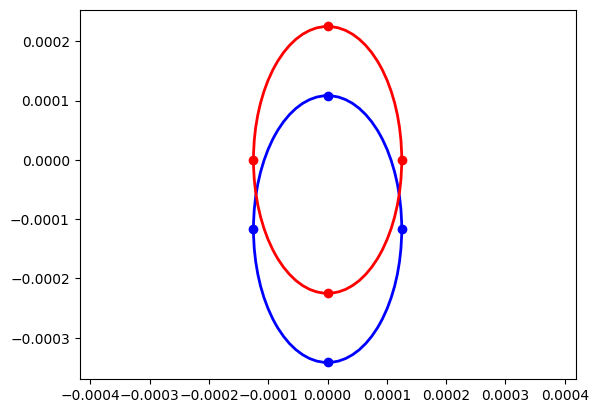

In [48]:
#plot first 2 coords of hits
# set axes equal
light_w = np.linalg.norm(light_hits[0] - light_hits[1])
light_h = np.linalg.norm(light_hits[2] - light_hits[3])
light_center = np.mean(light_hits[0:4], axis=0)
light_ellipse = Ellipse(xy=(light_center[:-1]), width=light_w, height=light_h, angle=np.rad2deg(axis),
                        edgecolor='b', fc='None', lw=2)

camera_w = np.linalg.norm(camera_hits[0] - camera_hits[1])
camera_h = np.linalg.norm(camera_hits[2] - camera_hits[3])
camera_center = np.mean(camera_hits[0:4], axis=0)
camera_ellipse = Ellipse(xy=(camera_center[:-1]), width=camera_w, height=camera_h, angle=np.rad2deg(axis),
                        edgecolor='r', fc='None', lw=2)

fig, ax = plt.subplots()
ax.add_patch(light_ellipse)
ax.set_aspect('equal', adjustable='datalim')
ax.scatter(light_hits[:,0], light_hits[:,1], c='blue')
ax.scatter(camera_hits[:,0], camera_hits[:,1], c='red')

ax.add_patch(camera_ellipse)
plt.show()

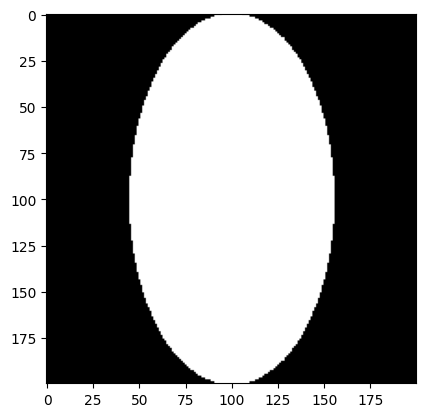

In [49]:
# Image dimensions
height, width = 200, 200
im_center = (height//2, width//2)

# Create a blank black image
image = np.zeros((height, width, 3), dtype=np.uint8)

# Define ellipse parameters
center = im_center  # (x, y) center of the ellipse
major_axis = max(camera_w, camera_h)  # Major axis of the ellipse
minor_axis = min(camera_w, camera_h)  # Minor axis of the ellipse

ratio = height/2/major_axis

im_w = (camera_w * ratio).astype(int)
im_h = (camera_h * ratio).astype(int)

cam_axes = (im_w, im_h)    # (width/2, height/2)
angle = np.rad2deg(-axis)         # Rotation angle in degrees
start_angle = 0    # Start of the ellipse arc
end_angle = 360    # End of the ellipse arc
color = (255, 255, 255)  # White color in BGR
thickness = -1      # Thickness of the ellipse line

# Draw the ellipse
cam_mask = cv2.ellipse(image, center, cam_axes, angle, start_angle, end_angle, color, thickness)
plt.imshow(cam_mask)

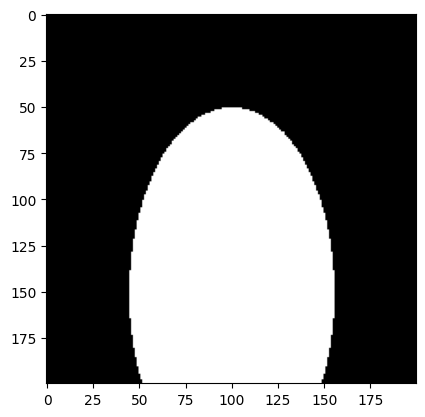

In [50]:
# Image dimensions
im_center = (height//2, width//2)

# Create a blank black image
image = np.zeros((height, width, 3), dtype=np.uint8)

# Define ellipse parameters
offset = (light_center - camera_center) * ratio*2
center = im_center - offset[:-1] # (x, y) center of the ellipse
light_c = center.astype(int)

im_w = (light_w * ratio).astype(int)
im_h = (light_h * ratio).astype(int)

light_axes = (im_w, im_h)    # (width/2, height/2)
angle = np.rad2deg(axis)         # Rotation angle in degrees
start_angle = 0    # Start of the ellipse arc
end_angle = 360    # End of the ellipse arc
color = (255, 255, 255)  # White color in BGR
thickness = -1      # Thickness of the ellipse line

# Draw the ellipse
light_mask = cv2.ellipse(image, light_c, light_axes, -angle, start_angle, end_angle, color, thickness)
plt.imshow(light_mask)

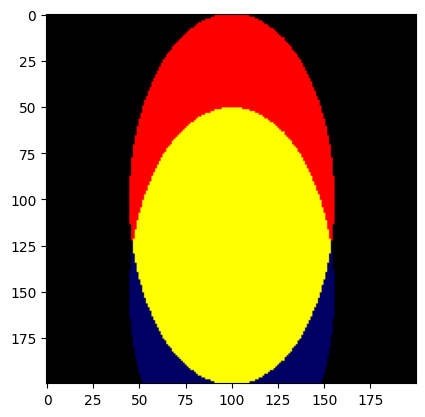

In [51]:
# combine masks
# where both are white -> yellow

mask = np.zeros((width, height, 3), dtype=np.uint8)
mask[light_mask[:, :, 0] == 255] = [0, 0, 100]
mask[cam_mask[:, :, 0] == 255] = [255, 0, 0]
mask[(cam_mask[:, :, 0] == 255) & (light_mask[:, :, 0] == 255)] = [255, 255, 0]
plt.imshow(mask)

In [52]:
def pixel_space(point):
    point = np.array(point)
    point = point - retina
    point = point * ratio
    point = point + (im_center[0], im_center[1], 0)
    point = point.astype(int)
    return point

[ 100   72 -230]
[ 100  100 -230]


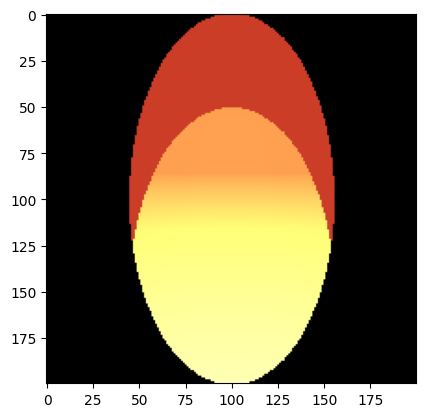

In [74]:
im = mask.copy()
# transform image_point to pixel coordinates
image_point_px = pixel_space(image_point)
image_point_cam_px = pixel_space(image_point_cam)
print(image_point_px)
print(image_point_cam_px)

kd = np.array([1, 1, 0.4])*0.1
ka = np.array([1, 0.3, 0.2])*0.4#np.pi * kd
ks = np.array([1, 1, 0.4])*0.5
shininess = 0.8

La = np.array([1, 1, 1])*2
Le = np.array([1, 1, 1])*4

# iterate over the yellow pixels of mask
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        outRadience = np.zeros(3)
        if np.array_equal(im[i, j], [255, 255, 0]):
            hit = np.array([j, i, 0])
            light_ray = Ray(image_point_px, hit)
            camera_ray = Ray(image_point_cam_px, hit)

            lens_center_px = pixel_space(lens)
            lens_plane_px = Plane(lens_center_px, np.array([0, 0, 1]))
            entry_point = lens_plane_px.intersect(light_ray)
            light_px = pixel_space(light)
            d_im = np.linalg.norm(entry_point - image_point_px)
            d_lens = np.linalg.norm(entry_point - light_px)
            d_blur = np.linalg.norm(image_point_px - hit)
            d_sum = d_im + d_lens + d_blur
            d_sum = d_sum/ratio
            
            normal = np.array([0, 0, -1])

            outRadience = np.zeros(3)
            outRadience += ka * La

            cosTheta = np.dot(-light_ray.dir, normal)
            if cosTheta > 0 and True:
                LeIn = Le / (d_sum)
                outRadience += kd * LeIn * cosTheta

                halfway = -(-light_ray.dir + camera_ray.dir) / np.linalg.norm(-light_ray.dir + camera_ray.dir)

                cosDelta = np.dot(halfway, normal)
                if cosDelta > 0:
                    outRadience += LeIn * ks * pow(cosDelta, shininess)
            # clamp to 0-1
            outRadience = np.clip(outRadience, 0, 1)
        elif np.array_equal(im[i, j], [255, 0, 0]):
            outRadience += ka * La
        else:
            pass
        im[i, j] = outRadience * 255
        
plt.imshow(im)

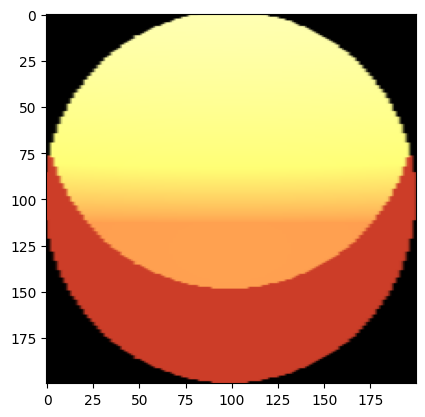

In [75]:
# transform the image
# rotate by angle

#im = mask.copy()
rows, cols = im.shape[:2]
M = cv2.getRotationMatrix2D((cols/2, rows/2), np.rad2deg(-axis), 1)
im = cv2.warpAffine(im, M, (cols, rows))
# scale along x axis
im = cv2.resize(im, (int(cols*cam_axes[1]/cam_axes[0]), rows))
# move to the right position
dx = center[0] - center[0]*cam_axes[1]/cam_axes[0]
dy = center[1] - center[1]

translation_mx = np.float32([[1, 0, dx], [0, 1, dy]])
im = cv2.warpAffine(im, translation_mx, (cols, rows))
# rotate back
M = cv2.getRotationMatrix2D((cols/2, rows/2), np.rad2deg(axis), 1)
im = cv2.warpAffine(im, M, (cols, rows))


if R < 0:
    # invert image around center
    im = cv2.flip(im, 0)
    im = cv2.flip(im, 1)
plt.imshow(im)